# LEARNING RATE AND EPOCH OPTIMIZATION IN THE FINE-TUNING PROCESS FOR INDOBERT'S PERFORMANCE ON SENTIMENT ANALYSIS OF MYTELKOMSEL APP REVIEWS

Muhammad Naufal Zaidan - 1301203228

# **Preparation**

In [ ]:
!pip install emoji

In [ ]:
import torch
import numpy as np
from transformers import BertTokenizer
import pandas as pd
from tabulate import tabulate
import re
import emoji
import nltk
nltk.download('punkt')
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from wordcloud import WordCloud


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
df=pd.read_excel('Dataset.xlsx') #baca dataset

In [ ]:
#drop kolom yang tida dibutuhkan
df.drop(columns=['KET','Unnamed: 5', 'userName', 'score', 'at'], inplace=True)
df.rename(columns={'Label': 'label', 'content': 'text'}, inplace=True)

In [ ]:
#menampilkan 5 baris dataset
df.iloc[7955:7960]

,text,label
7955,Mantab..,1.0
7956,mudah di gunakan,1.0
7957,mantab,1.0
7958,Ongen,1.0
7959,"JARINGAN LAMBAT, BUKA APLIKASI PUN SUSAHSUSAHNYA",0.0


In [ ]:
#menampilkan jumlah baris dan kolom
df.shape

(9000, 2)

In [ ]:
#tampilkan label
df['label'].value_counts()

label
0.0    5790
1.0    3201
Name: count, dtype: int64

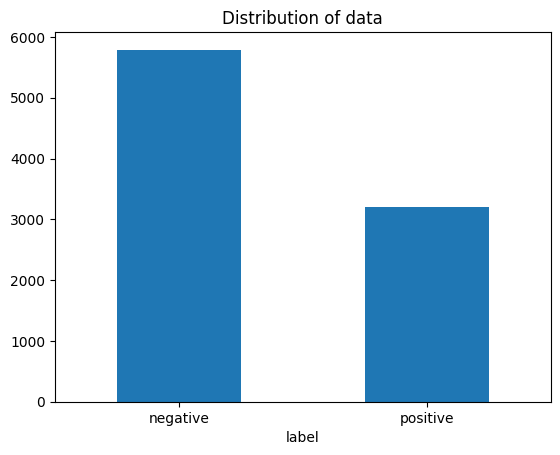

In [ ]:
#chartbar distribusi data
ax = df.groupby('label').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax = ax.set_xticklabels(['negative','positive'], rotation=0)

# **Case Folding & Data Cleaning**

In [ ]:
# Menyimpan daftar karakter yang akan digunakan untuk membersihkan teks dari karakter yang berulang.
character = ['.',',',';',':','-,','...','?','!','(',')','[',']','{','}','<','>','"','/','\'','#','-','@',
             'a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z',
             'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']

# hapus karakter yang berulang
def repeatcharClean(text):
  for i in range(len(character)):
    charac_long = 5
    while charac_long > 2:
      char = character[i]*charac_long
      text = text.replace(char,character[i])
      charac_long -= 1
  return text


def clean_review(text):
  # ubah text menjadi huruf kecil
  text = text.lower()
  # ubah enter menjadi spasi
  text = re.sub(r'\n', ' ', text)
  # hapus emoji
  text = emoji.demojize(text)
  text = re.sub(':[A-Za-z_-]+:', ' ', text) # delete emoji
  # hapus emoticon
  text = re.sub(r"([xX;:]'?[dDpPvVoO3)(])", ' ', text)
  # hapus link
  text = re.sub(r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})", "", text)
  # hapus usename
  text = re.sub(r"@[^\s]+[\s]?", ' ', text)
  # hapus hashtag
  text = re.sub(r'#(\S+)', r'\1', text)
  # hapus angka dan beberapa simbol
  text = re.sub('[^a-zA-Z,.?!]+',' ',text)
  # hapus karakter berulang
  text = repeatcharClean(text)
  # clear spasi
  text = re.sub('[ ]+',' ',text)
  return text

# memproses dataframe
def preprocess_v1(df):
  df_pp = df.copy()
  df_pp.text = df_pp.text.map(clean_review) # menghapus baris yang kosong, dan mengembalikan dataframe yang sudah diproses.
  df_pp.text.replace('', np.nan, inplace=True)
  df_pp.text.replace(' ', np.nan, inplace=True)
  df_pp.dropna(subset=['text'], inplace=True)
  return df_pp


df_v1 = preprocess_v1(df)


In [ ]:
df_v1.iloc[7905:7912]

,text,label
7956,mudah di gunakan,1.0
7957,mantab,1.0
7958,ongen,1.0
7959,"jaringan lambat, buka aplikasi pun susahsusahnya",0.0
7960,bagus,1.0
7961,terpromo,1.0
7962,sangatlah baik,1.0


Vizulatitation

In [ ]:
def make_word(column):

    word_list = []

    for word in column:
        cleaned_list = word.split(' ')
        word_list.extend(cleaned_list)

    word = ' '.join(word_list)
    word = re.sub('[ ]+',' ',word)

    return word

In [ ]:
word = make_word(df_v1.text)

In [ ]:
#UNIQUE WORD COUNTER
print(f"Jumlah kata unik: {len(set(word.split(' ')))}")

Jumlah kata unik: 11509


Word Frequent Vizualitation

In [ ]:
def word_freq(word, top):
    tokenized_word = word_tokenize(word)
    freqdist = FreqDist(tokenized_word)
    freqdist = freqdist.most_common(top)

    text = [tup[0] for tup in freqdist]
    freq = [tup[1] for tup in freqdist]
    df = pd.DataFrame({'Word':text, 'Count':freq})

    return df

In [ ]:
word_freq = word_freq(word, 20)

<ipython-input-16-61ab76caae9e>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Word', y='Count', data=word_freq, ax=ax1, palette='hsv')


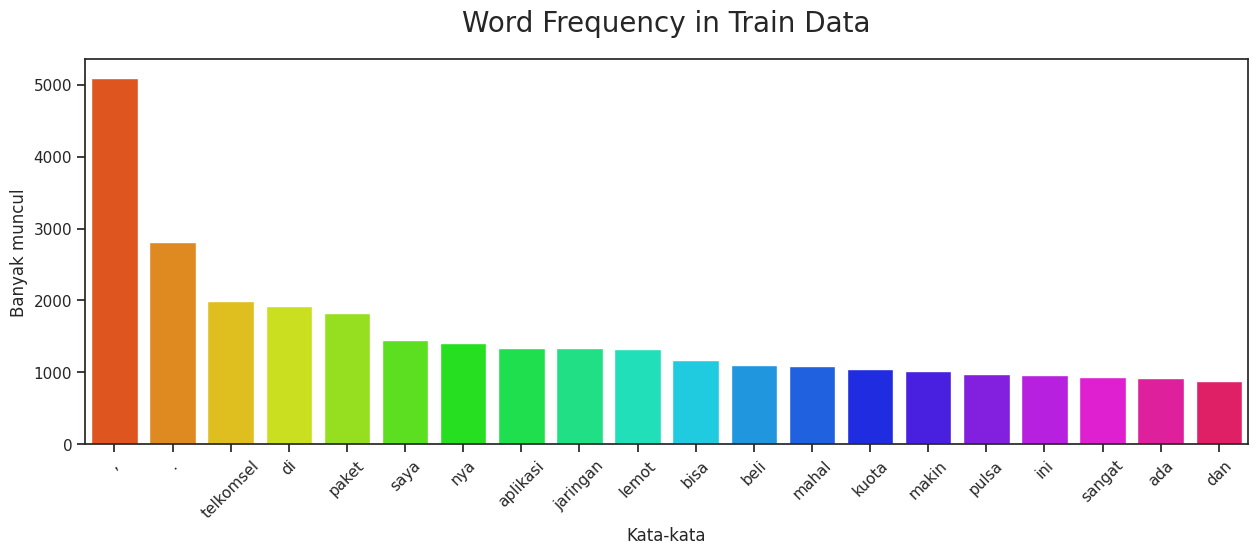

In [ ]:
plt.style.use('default')
sns.set(style='ticks', palette='Set2')
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.titlepad'] = 20

f, ax1 = plt.subplots(1, figsize=(15, 5))

sns.barplot(x='Word', y='Count', data=word_freq, ax=ax1, palette='hsv')
ax1.set_title('Word Frequency in Train Data')
ax1.tick_params(axis='x', rotation=45)
plt.xlabel("Kata-kata")
plt.ylabel("Banyak muncul")


plt.show()


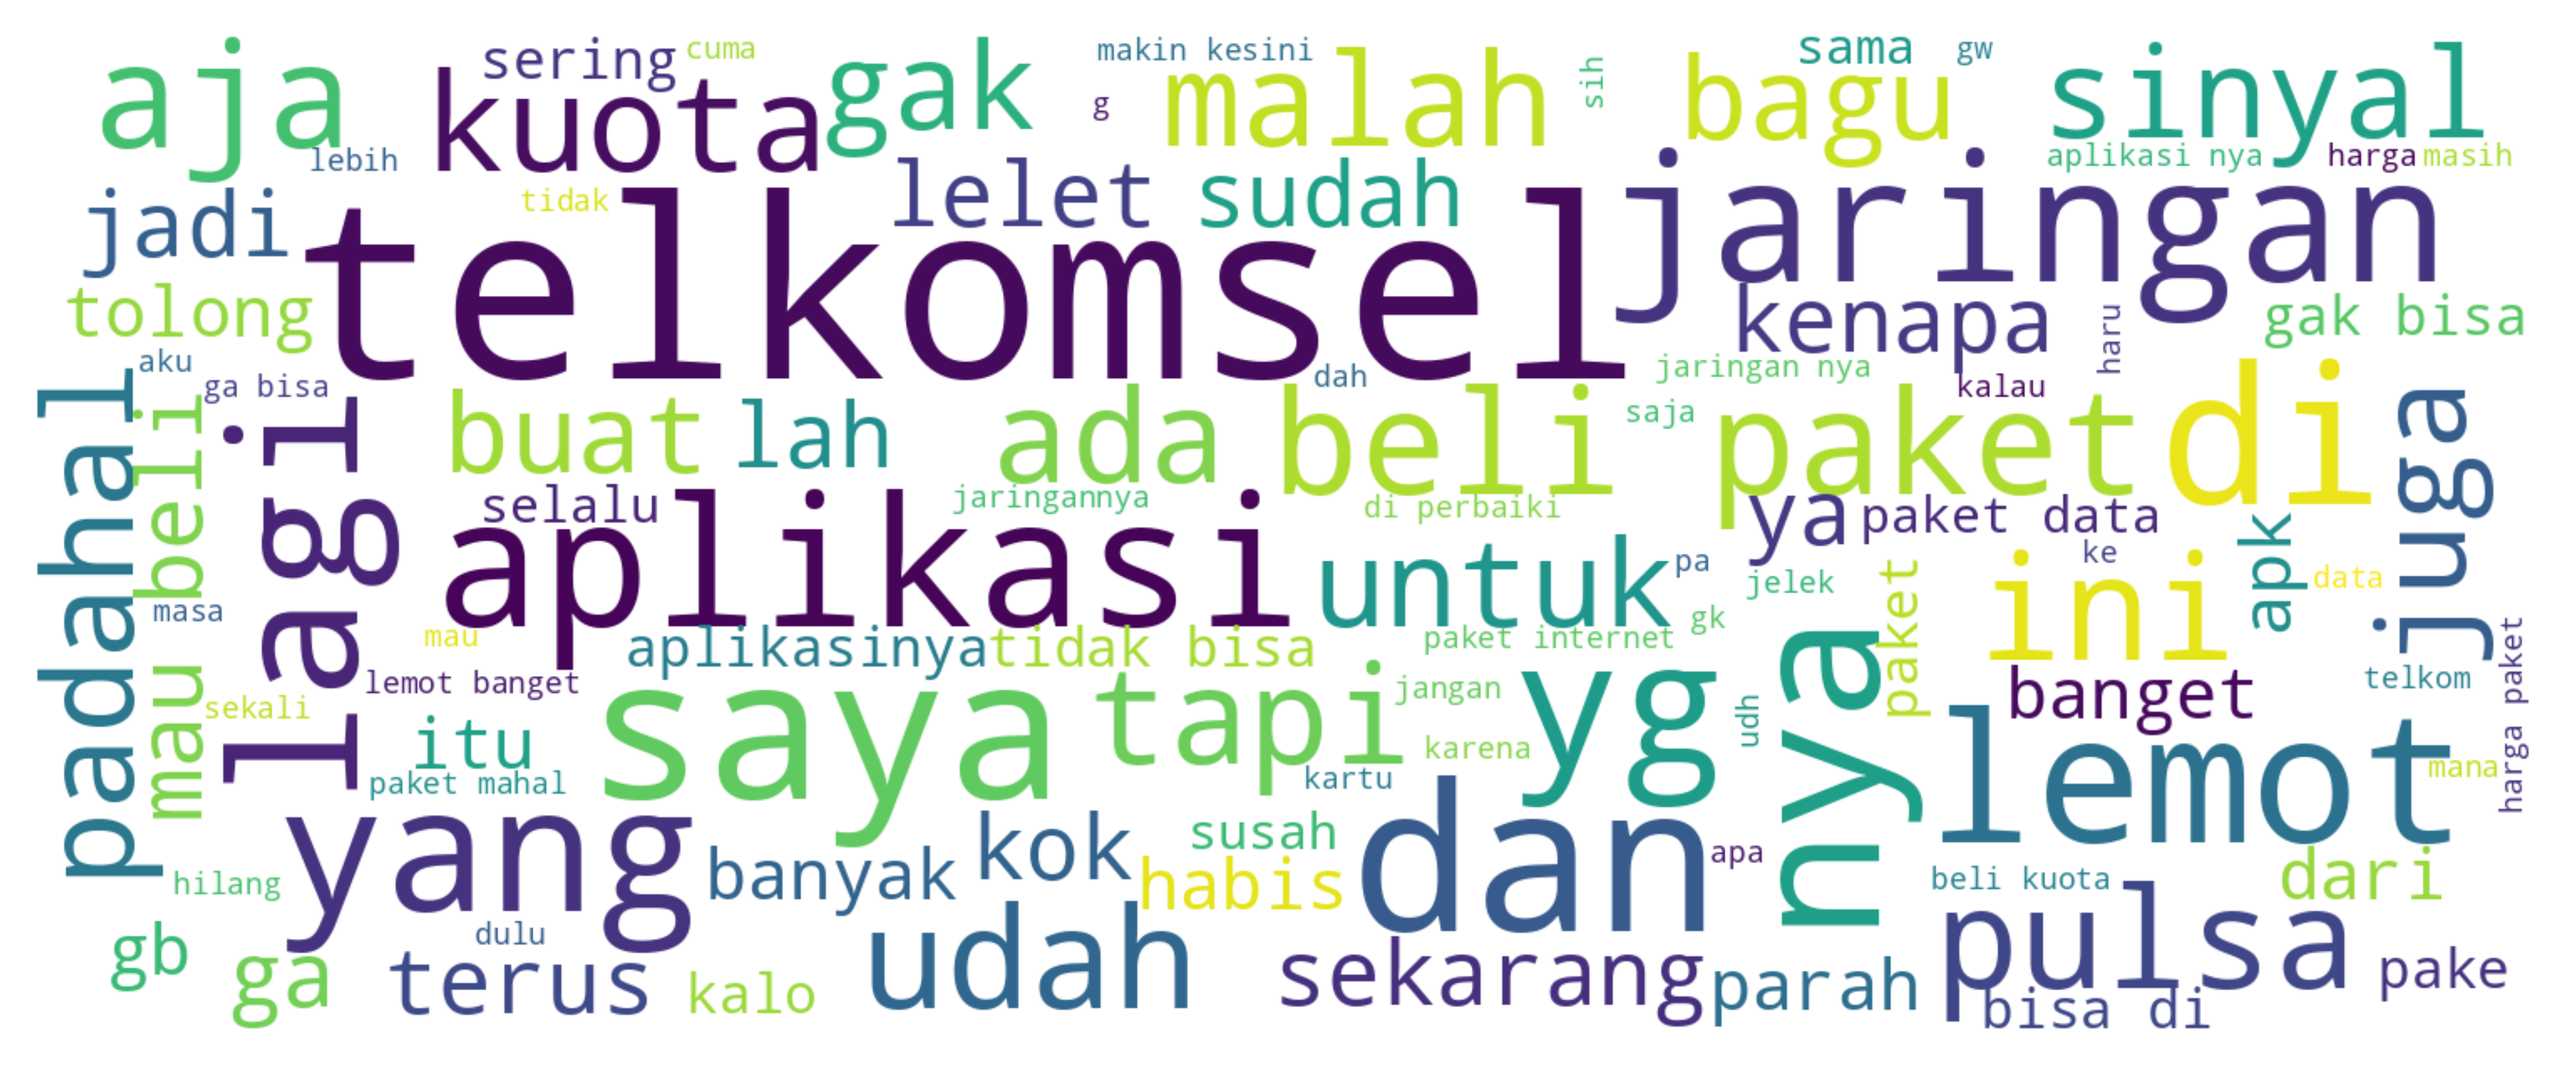

In [ ]:
# scale buat resolusi
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", width = 500, height = 200, scale=3).generate(word)

# Atur ukuran gambar dan resolusi
plt.figure(figsize=(10, 6), dpi=600)
# Tampilkan WordCloud
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# **Tokenizing and Normalization**

In [ ]:
# Menggunakan tokenizer dari model IndoBERT untuk mengubah teks menjadi token.
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# Mendefinisikan Kelas Dataset untuk PyTorch
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [label for label in df['label']]
        self.texts = [tokenizer(text,
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [ ]:
# import kamus untuk normalisasi
kamus_alay=pd.read_csv('kamus_alay.csv')

In [ ]:
normalize_word_dict = {}
for index, row in kamus_alay.iterrows():
    if row[0] not in normalize_word_dict:
        normalize_word_dict[row[0]] = row[1]

def normalize_review(text):
  # tokenize
  list_text = word_tokenize(text)
  # ubah bahasa tidak baku
  list_text = [normalize_word_dict[term] if term in normalize_word_dict else term for term in list_text]
  # gabung kembali kalimat
  text = " ".join(list_text)
  return text

# Memproses DataFrame dengan Normalisasi
def preprocess(df):
    df_pp = df.copy()
    df_pp['text'] = df_pp['text'].map(clean_review)
    df_pp['text'] = df_pp['text'].map(normalize_review)
    df_pp['text'].replace('', np.nan, inplace=True)
    df_pp['text'].replace(' ', np.nan, inplace=True)
    df_pp.dropna(subset=['text'], inplace=True)
    return df_pp

# Preprocess the dataset
df_processed = preprocess(df)
df_processed.iloc[21:26]


,text,label
21,"saya isi pulsa tanggal , ribu tiba tiba di pot...",0.0
22,"tiap aplikasinya di buka selalu lama , lambat ...",0.0
23,sisa pembelian pulsa kok ke sedot sih maksudny...,0.0
24,stamp berhadiahnya tipu tipu .. saat dikalim b...,0.0
25,harga paket elit jaringan syulit.nonton iklann...,0.0


In [ ]:
# Instalasi dan Penerapan Oversampling
!pip install -U imbalanced-learn

In [ ]:
df = df_v1.dropna()


In [ ]:
df['label'] = df['label'].replace(4,1)

<ipython-input-24-655f11567c92>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df['label'].replace(4,1)


In [ ]:
from tkinter.constants import Y
from imblearn.over_sampling import RandomOverSampler

X = df[['text']]
Y = df['label']
ros = RandomOverSampler(random_state=1)
X_new, y_new = ros.fit_resample(X,Y)

In [ ]:
df = X_new
df['label'] = y_new

split data

In [ ]:
from sklearn.model_selection import train_test_split
df_train, df_temp = train_test_split(df, test_size=0.3, random_state=42, stratify=df['label'])
df_val, df_test = train_test_split(df_temp, test_size=0.3, random_state=42, stratify=df_temp['label'])

# 70 test 20 val 10 test

print(len(df_train),len(df_val), len(df_test))

8100 2430 1042


<Axes: xlabel='label', ylabel='count'>

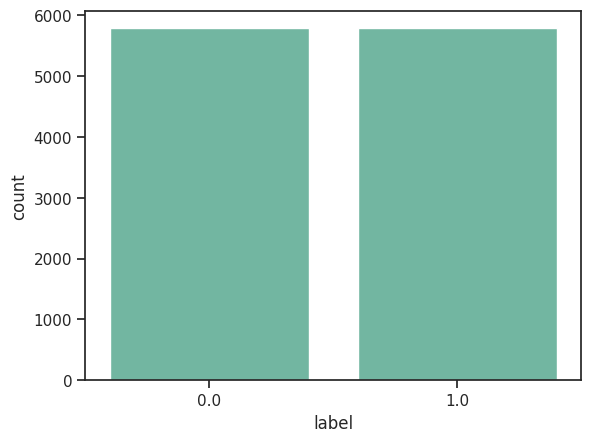

In [ ]:
sns.countplot(data=df, x='label')

# **BERT Fine Tuning**

In [ ]:
from torch import nn # Mengimpor modul nn dari PyTorch yang menyediakan kelas-kelas untuk membuat jaringan neural.
from transformers import BertModel # Mengimpor BertModel dari library transformers, yang berisi implementasi dari model BERT.

class BertClassifier(nn.Module): #Mendefinisikan kelas BertClassifier yang merupakan subclass dari nn.Module

    def __init__(self, dropout=0.5): # Konstruktor dari kelas BertClassifier yang menerima argumen dropout rate

        super(BertClassifier, self).__init__() # Memanggil konstruktor dari kelas nn.Module

        self.bert = BertModel.from_pretrained('indobenchmark/indobert-base-p2') # Menginisialisasi model BERT dengan menggunakan pretrained model indobenchmark/indobert-base-p2
        self.dropout = nn.Dropout(dropout) # Menginisialisasi lapisan dropout untuk mencegah overfitting dengan dropout rate 0.5.
        self.linear = nn.Linear(768,2) # Menginisialisasi lapisan linear (fully connected layer) yang mengubah dimensi keluaran BERT (768) menjadi 2 (output untuk klasifikasi).
        self.relu = nn.Sigmoid() # Menggunakan fungsi aktivasi Sigmoid untuk mengubah output linear.

    def forward(self, input_id, mask): # Mendefinisikan metode forward untuk melewatkan input melalui jaringan.

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False) # Mendapatkan keluaran dari BERT. pooled_output adalah representasi yang digunakan untuk klasifikasi.
        dropout_output = self.dropout(pooled_output) # Menerapkan dropout pada keluaran BERT untuk mencegah overfitting.
        linear_output = self.linear(dropout_output) # Menerapkan lapisan linear pada keluaran dropout.
        final_layer = self.relu(linear_output) # Menerapkan fungsi aktivasi Sigmoid pada keluaran linear untuk mendapatkan probabilitas dari masing-masing kelas.

        return final_layer # Mengembalikan hasil akhir dari neuron

In [ ]:
# Mengimpor callback untuk early stopping dan strategi interval evaluasi dari transformers.
from transformers import EarlyStoppingCallback, IntervalStrategy

In [ ]:
!pip install accelerate -U

In [ ]:
!pip install transformers==4.30

In [ ]:
from transformers import TrainingArguments
args = TrainingArguments( # Digunakan untuk mengatur parameter pelatihan seperti batch size, strategi evaluasi, dan pengaturan lainnya untuk pelatihan model.
    f"training_with_callbacks",
    evaluation_strategy = IntervalStrategy.STEPS, # Menentukan bahwa evaluasi dilakukan setiap beberapa langkah
    eval_steps = 2, # Evaluasi dan penyimpanan model dilakukan setiap 2 langkah
    save_total_limit = 5, # Hanya menyimpan 5 model terakhir, model lama akan dihapus.
    per_device_train_batch_size=16, # Mengatur ukuran batch untuk pelatihan pada setiap perangkat menjadi 16.
    per_device_eval_batch_size=16, #Mengatur ukuran batch untuk evaluasi pada setiap perangkat menjadi 16.
    weight_decay=0.01, # Menentukan tingkat penurunan bobot untuk regularisasi.
    push_to_hub=False, # Tidak akan mendorong model ke hub.
    metric_for_best_model = 'f1', # Menggunakan skor F1 sebagai metrik untuk memilih model terbaik.
    load_best_model_at_end=True) # Memuat model terbaik di akhir pelatihan.

# **Optimization**

In [ ]:
from torch.optim import Adam #impor optimasi adam
from tqdm import tqdm # impor tqdm untuk menampilkan progress bar selama iterasi.

from sklearn.metrics import precision_score, recall_score, f1_score # Mengimpor fungsi untuk menghitung metrik evaluasi seperti precision, recall, dan F1-score.

def train(model, train_data, val_data, learning_rate, epochs, args, # Mendefinisikan fungsi train untuk melatih model.
          callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]):
    train, val = Dataset(train_data), Dataset(val_data) # Mengubah data latih dan validasi menjadi dataset PyTorch.
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=16, shuffle=True) # Membuat dataloader untuk data latih dengan batch size 16 dan shuffle data.
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=16) #  Membuat dataloader untuk data validasi dengan batch size 16.

    use_cuda = torch.cuda.is_available() # Mengecek apakah CUDA tersedia untuk menggunakan GPU.
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss() # Menginisialisasi fungsi loss CrossEntropy untuk klasifikasi.
    optimizer = Adam(model.parameters(), lr=learning_rate) # Menginisialisasi optimizer Adam dengan learning rate tertentu.

    if use_cuda: # Jika GPU tersedia, model dan fungsi loss dipindahkan ke GPU.
        model = model.cuda()
        criterion = criterion.cuda()

    for epoch_num in range(epochs): # Iterasi melalui jumlah epoch yang ditentukan.
    # Menginisialisasi variabel untuk menghitung akurasi dan loss total selama pelatihan.
        total_acc_train = 0
        total_loss_train = 0
    # Menginisialisasi list untuk menyimpan label dan prediksi selama pelatihan.
        all_train_labels = []
        all_train_preds = []

        for train_input, train_label in tqdm(train_dataloader): # Looping melalui batch dalam dataloader pelatihan dengan progress bar.
            train_label = train_label.to(device) # Memindahkan label ke perangkat yang digunakan.
            mask = train_input['attention_mask'].to(device) # Memindahkan attention mask ke perangkat yang digunakan.
            input_id = train_input['input_ids'].squeeze(1).to(device) #  Memindahkan input ID ke perangkat yang digunakan dan menghilangkan dimensi ekstra.

            output = model(input_id, mask) # Memasukkan input ke model untuk mendapatkan output.

            batch_loss = criterion(output, train_label.long()) # Menghitung loss untuk batch ini.
            total_loss_train += batch_loss.item()  # Menambahkan batch loss ke total loss.

            acc = (output.argmax(dim=1) == train_label).sum().item() # Menghitung akurasi batch ini dengan membandingkan prediksi dengan label sebenarnya.
            total_acc_train += acc # Menambahkan akurasi batch ini ke total akurasi pelatihan.

            # Collect predictions and labels for later metric calculation
            all_train_labels.extend(train_label.cpu().numpy())
            all_train_preds.extend(output.argmax(dim=1).cpu().numpy())

            model.zero_grad()
            batch_loss.backward()
            optimizer.step()

        # Calculate precision, recall, and F1 score for training set
        train_precision = precision_score(all_train_labels, all_train_preds, average='weighted')
        train_recall = recall_score(all_train_labels, all_train_preds, average='weighted')
        train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted')
        # evaluasi pada data validasi
        total_acc_val = 0 # Menginisialisasi variabel untuk menghitung akurasi dan loss total selama evaluasi.
        total_loss_val = 0 # Menginisialisasi list untuk menyimpan label dan prediksi selama evaluasi.
        all_val_labels = []
        all_val_preds = []


        with torch.no_grad(): # Mematikan kalkulasi gradien selama evaluasi untuk menghemat memori dan mempercepat proses.
            for val_input, val_label in val_dataloader: # Looping melalui batch dalam dataloader evaluasi.
                val_label = val_label.to(device) # Memindahkan label validasi ke perangkat yang digunakan.
                mask = val_input['attention_mask'].to(device) # Memindahkan attention mask ke perangkat yang digunakan.
                input_id = val_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask) # Memasukkan input validasi ke model untuk mendapatkan output.

                batch_loss = criterion(output, val_label.long()) # Menghitung loss untuk batch ini selama validasi.
                total_loss_val += batch_loss.item() # Menambahkan batch loss ke total loss validasi.

                acc = (output.argmax(dim=1) == val_label).sum().item() # Menghitung akurasi batch ini dengan membandingkan prediksi dengan label validasi.
                total_acc_val += acc # Menambahkan akurasi batch ini ke total akurasi validasi

                # Collect predictions and validation labels for later metric calculation
                all_val_labels.extend(val_label.cpu().numpy()) # Menyimpan semua label validasi batch ini.
                all_val_preds.extend(output.argmax(dim=1).cpu().numpy()) # Menyimpan semua prediksi validasi batch ini.

        # Calculate precision, recall, and F1 score for validation set
        val_precision = precision_score(all_val_labels, all_val_preds, average='weighted')
        val_recall = recall_score(all_val_labels, all_val_preds, average='weighted')
        val_f1 = f1_score(all_val_labels, all_val_preds, average='weighted')


        results = [epoch_num + 1,learning_rate,total_loss_train / len(train_data),total_acc_train / len(train_data),
                   train_precision,train_recall,train_f1,total_loss_val / len(val_data),total_acc_val / len(val_data),val_precision,val_recall,val_f1]
        # Menampilkan rata-rata loss dan akurasi pelatihan dan  rata-rata loss dan akurasi validasi.
        print(
            f'Epochs: {epoch_num + 1} | Learning Rate: {learning_rate} | Train Loss: {total_loss_train / len(train_data): .3f} '
            f'| Train Accuracy: {total_acc_train / len(train_data): .3f} '
            f'| Train Precision: {train_precision: .3f} | Train Recall: {train_recall: .3f} | Train F1: {train_f1: .3f} '
            f'| Val Loss: {total_loss_val / len(val_data): .3f} '
            f'| Val Accuracy: {total_acc_val / len(val_data): .3f} '
            f'| Val Precision: {val_precision: .3f} | Val Recall: {val_recall: .3f} | Val F1: {val_f1: .3f}')
        return results, model

# **Mencari Akurasi dengan Learning Rate terbaik**

In [ ]:
columns_result = ['epoch', 'learning_rate', 'train_loss', 'train_accuracy',
           'train_precision', 'train_recall', 'train_f1',
           'val_loss', 'val_accuracy', 'val_precision',
           'val_recall', 'val_f1']

df_result = pd.DataFrame(columns=columns_result)

In [ ]:
df_result.shape

(0, 12)

In [ ]:
import pandas as pd

EPOCHS_RANGE = [1]
LEARNING_RATES = [1e-5, 1e-6, 1e-7, 2e-5, 5e-5]
models = []

for epochs in EPOCHS_RANGE:
    for lr in LEARNING_RATES:

        model = BertClassifier()
        result, model = train(model, df_train, df_val, lr, epochs, args, callbacks=[EarlyStoppingCallback(early_stopping_patience=3)])
        models.append(model)


        # result_row = {
        #     'Epochs': epochs,
        #     'Learning Rate': lr,
        # }
        df_result.loc[len(df_result)] = result



/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

100%|██████████| 507/507 [11:14<00:00,  1.33s/it]


Epochs: 1 | Learning Rate: 1e-05 | Train Loss:  0.024 | Train Accuracy:  0.941 | Train Precision:  0.942 | Train Recall:  0.941 | Train F1:  0.941 | Val Loss:  0.022 | Val Accuracy:  0.959 | Val Precision:  0.959 | Val Recall:  0.959 | Val F1:  0.959


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 507/507 [11:16<00:00,  1.33s/it]


Epochs: 1 | Learning Rate: 1e-06 | Train Loss:  0.029 | Train Accuracy:  0.888 | Train Precision:  0.888 | Train Recall:  0.888 | Train F1:  0.888 | Val Loss:  0.023 | Val Accuracy:  0.949 | Val Precision:  0.949 | Val Recall:  0.949 | Val F1:  0.949


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 507/507 [11:16<00:00,  1.33s/it]


Epochs: 1 | Learning Rate: 1e-07 | Train Loss:  0.041 | Train Accuracy:  0.698 | Train Precision:  0.701 | Train Recall:  0.698 | Train F1:  0.697 | Val Loss:  0.038 | Val Accuracy:  0.845 | Val Precision:  0.846 | Val Recall:  0.845 | Val F1:  0.845


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 507/507 [11:16<00:00,  1.33s/it]


Epochs: 1 | Learning Rate: 2e-05 | Train Loss:  0.023 | Train Accuracy:  0.941 | Train Precision:  0.942 | Train Recall:  0.941 | Train F1:  0.941 | Val Loss:  0.023 | Val Accuracy:  0.947 | Val Precision:  0.948 | Val Recall:  0.947 | Val F1:  0.947


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 507/507 [11:15<00:00,  1.33s/it]


Epochs: 1 | Learning Rate: 5e-05 | Train Loss:  0.026 | Train Accuracy:  0.901 | Train Precision:  0.905 | Train Recall:  0.901 | Train F1:  0.901 | Val Loss:  0.031 | Val Accuracy:  0.823 | Val Precision:  0.862 | Val Recall:  0.823 | Val F1:  0.818


In [ ]:
df_result

,epoch,learning_rate,train_loss,train_accuracy,train_precision,train_recall,train_f1,val_loss,val_accuracy,val_precision,val_recall,val_f1
0,1.0,1.000000e-05,0.023540,0.941358,0.941543,0.941358,0.941352,0.022199,0.958848,0.959251,0.958848,0.958839
1,1.0,1.000000e-06,0.028880,0.888272,0.888320,0.888272,0.888268,0.023486,0.948560,0.948815,0.948560,0.948552
2,1.0,1.000000e-07,0.040665,0.697654,0.700652,0.697654,0.696521,0.037603,0.845267,0.845681,0.845267,0.845221
3,1.0,2.000000e-05,0.023390,0.941481,0.941606,0.941481,0.941477,0.022858,0.947325,0.947563,0.947325,0.947318
4,1.0,5.000000e-05,0.025811,0.900988,0.904858,0.900988,0.900750,0.030685,0.822634,0.861634,0.822634,0.817719


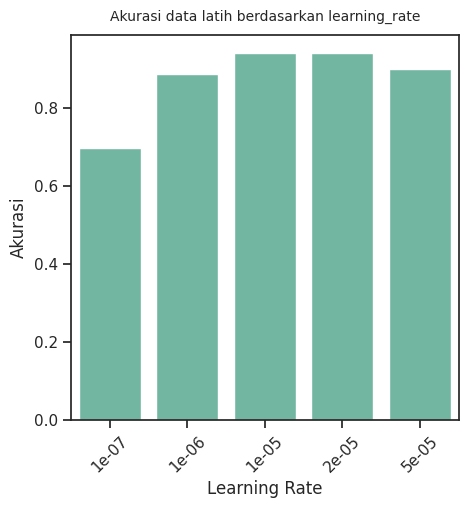

In [ ]:
plt.style.use('default')
sns.set(style='ticks', palette='Set2')
mpl.rcParams['axes.titlesize'] = 10
mpl.rcParams['axes.titlepad'] =10

f, ax1 = plt.subplots(1, figsize=(5, 5))

#sns.barplot(x='learning_rate', y='train_accuracy', data=df_result, ax=ax1, palette='hsv')
sns.barplot(x='learning_rate', y='train_accuracy', data=df_result, ax=ax1)
ax1.set_title('Akurasi data latih berdasarkan learning_rate')
ax1.tick_params(axis='x', rotation=45)
plt.xlabel("Learning Rate")
plt.ylabel("Akurasi")

plt.show()


<ipython-input-40-4484a300c352>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='learning_rate', y='train_accuracy', data=df_result, ax=ax1, palette='hsv')


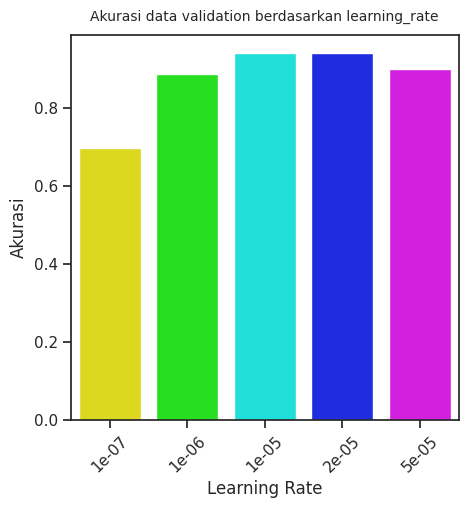

In [ ]:
plt.style.use('default')
sns.set(style='ticks', palette='Set2')
mpl.rcParams['axes.titlesize'] = 10
mpl.rcParams['axes.titlepad'] =10

f, ax1 = plt.subplots(1, figsize=(5, 5))

sns.barplot(x='learning_rate', y='train_accuracy', data=df_result, ax=ax1, palette='hsv')
#sns.barplot(x='learning_rate', y='val_accuracy', data=df_result, ax=ax1)
ax1.set_title('Akurasi data validation berdasarkan learning_rate')
ax1.tick_params(axis='x', rotation=45)
plt.xlabel("Learning Rate")
plt.ylabel("Akurasi")

plt.show()

In [ ]:
from torch.nn.functional import softmax
def predict_text(model, sentence):
  # Tokenisasi
  tokens = tokenizer.encode_plus(sentence,
                                padding='max_length', max_length = 512, truncation=True,
                                  return_tensors="pt")

  device = next(model.parameters()).device
  tokens = {key: tensor.to(device) for key, tensor in tokens.items()}

  # Prediksi kelas
  with torch.no_grad():
      output = model(tokens['input_ids'], tokens['attention_mask'])
  #Hitung Probabilitas
  probs = softmax(output, dim=1)
  predicted_class = torch.argmax(output, dim=1).item()
  predicted_probabilities = probs.squeeze().tolist()

  # Print output
  print(f"Kalimat: {sentence} | Kelas prediksi: {predicted_class} ({max(predicted_probabilities)*100:.2f}%)")
  return predicted_class

In [ ]:
# prediksi klasifikasi sentimen dengan input kalimat
t = predict_text(models[0], "jaringan buruk")

Kalimat: jaringan buruk | Kelas prediksi: 0 (72.96%)


In [ ]:
#df_test['label'].values.tolist()

In [ ]:
# ambil teks dan label dari data uji (df_test), yang nantinya bisa dibandingkan dengan label asli (real_test) untuk evaluasi performa model
real_test = df_test['label'].values.tolist()
text_test = df_test['text'].values.tolist()
pred_test = []
for i in range(len(text_test)):
  pred = predict_text(models[0], text_test[i])
  pred_test.append(pred)

Kalimat: ini apk sudah ngawur, udah beli pulsa k waktu kuota mau abis pas mau beli paket malah gak bisa, eror dan sebagainya, ketika kuota abis pulsa malah ludes!! | Kelas prediksi: 0 (72.98%)
Kalimat: sangat membantu | Kelas prediksi: 1 (72.99%)
Kalimat: aplikasi gak berguna | Kelas prediksi: 0 (72.92%)
Kalimat: ga jelas, niat ga si bikin aplikasi? | Kelas prediksi: 0 (72.90%)
Kalimat: sialan pas update lemot,mau beli kuota susah amat ,padahal udah sukses tpi gak ada msuk | Kelas prediksi: 0 (73.00%)
Kalimat: telkomsel memang the best | Kelas prediksi: 1 (73.03%)
Kalimat: apa ini telkomsel udah harganya mahal jaringannya lemot pula lagi | Kelas prediksi: 0 (73.00%)
Kalimat: ok | Kelas prediksi: 1 (72.97%)
Kalimat: sangat bagus buat cek plsa sama kuota | Kelas prediksi: 1 (73.04%)
Kalimat: jaringan  | Kelas prediksi: 1 (72.97%)
Kalimat: bagus | Kelas prediksi: 1 (73.03%)
Kalimat: sangat baik | Kelas prediksi: 1 (73.03%)
Kalimat: server tidak merespon terus anjir.. pke wifi paket data j

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(real_test, pred_test)
print(report)

              precision    recall  f1-score   support

         0.0       0.95      0.98      0.97       521
         1.0       0.98      0.95      0.96       521

    accuracy                           0.96      1042
   macro avg       0.97      0.96      0.96      1042
weighted avg       0.97      0.96      0.96      1042



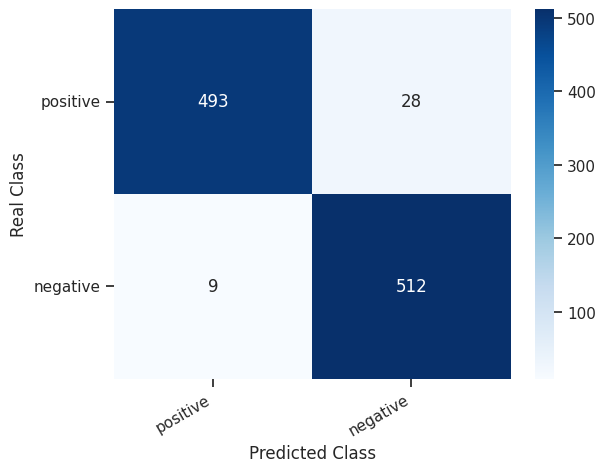

In [ ]:
from sklearn.metrics import confusion_matrix
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('Real Class')
  plt.xlabel('Predicted Class');

cm = confusion_matrix(real_test, pred_test, labels=[1, 0])
df_cm = pd.DataFrame(cm, index=['positive', 'negative'], columns=['positive', 'negative'])
show_confusion_matrix(df_cm)

EPOCH

# **Optimasi Epoch **

In [ ]:
from torch.optim import Adam
from tqdm import tqdm

from sklearn.metrics import precision_score, recall_score, f1_score

def trainEpoch(model, train_data, val_data, learning_rate, epochs, args,
          callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]):
    df_result = pd.DataFrame(columns=columns_result)

    train, val = Dataset(train_data), Dataset(val_data)
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    results = []

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()

    for epoch_num in range(epochs):
        total_acc_train = 0
        total_loss_train = 0
        all_train_labels = []
        all_train_preds = []

        for train_input, train_label in tqdm(train_dataloader):
            train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device)
            input_id = train_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            batch_loss = criterion(output, train_label.long())
            total_loss_train += batch_loss.item()

            acc = (output.argmax(dim=1) == train_label).sum().item()
            total_acc_train += acc

            # Collect predictions and labels for later metric calculation
            all_train_labels.extend(train_label.cpu().numpy())
            all_train_preds.extend(output.argmax(dim=1).cpu().numpy())

            model.zero_grad()
            batch_loss.backward()
            optimizer.step()

        # Calculate precision, recall, and F1 score for training set
        train_precision = precision_score(all_train_labels, all_train_preds, average='weighted')
        train_recall = recall_score(all_train_labels, all_train_preds, average='weighted')
        train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted')

        total_acc_val = 0
        total_loss_val = 0
        all_val_labels = []
        all_val_preds = []

        with torch.no_grad():
            for val_input, val_label in val_dataloader:
                val_label = val_label.to(device)
                mask = val_input['attention_mask'].to(device)
                input_id = val_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)

                batch_loss = criterion(output, val_label.long())
                total_loss_val += batch_loss.item()

                acc = (output.argmax(dim=1) == val_label).sum().item()
                total_acc_val += acc

                # Collect predictions and labels for later metric calculation
                all_val_labels.extend(val_label.cpu().numpy())
                all_val_preds.extend(output.argmax(dim=1).cpu().numpy())

        # Calculate precision, recall, and F1 score for validation set
        val_precision = precision_score(all_val_labels, all_val_preds, average='weighted')
        val_recall = recall_score(all_val_labels, all_val_preds, average='weighted')
        val_f1 = f1_score(all_val_labels, all_val_preds, average='weighted')

        df_result.loc[len(df_result)] = [epoch_num + 1,learning_rate,total_loss_train / len(train_data),total_acc_train / len(train_data),
                   train_precision,train_recall,train_f1,total_loss_val / len(val_data),total_acc_val / len(val_data),val_precision,val_recall,val_f1]

        results.append({
        'epoch': epoch_num + 1,
        'learning_rate': learning_rate,
        'train_loss': total_loss_train / len(train_data),
        'train_accuracy': total_acc_train / len(train_data),
        'train_precision': train_precision,
        'train_recall': train_recall,
        'train_f1': train_f1,
        'val_loss': total_loss_val / len(val_data),
        'val_accuracy': total_acc_val / len(val_data),
        'val_precision': val_precision,
        'val_recall': val_recall,
        'val_f1': val_f1
        })

        print(
            f'Epochs: {epoch_num + 1} | Learning Rate: {learning_rate} | Train Loss: {total_loss_train / len(train_data): .3f} '
            f'| Train Accuracy: {total_acc_train / len(train_data): .3f} '
            f'| Train Precision: {train_precision: .3f} | Train Recall: {train_recall: .3f} | Train F1: {train_f1: .3f} '
            f'| Val Loss: {total_loss_val / len(val_data): .3f} '
            f'| Val Accuracy: {total_acc_val / len(val_data): .3f} '
            f'| Val Precision: {val_precision: .3f} | Val Recall: {val_recall: .3f} | Val F1: {val_f1: .3f}')

    avg_result = []

    values_train_accuracy = [item['train_accuracy'] for item in results]
    average_train_accuracy = sum(values_train_accuracy) / len(values_train_accuracy)
    values_train_precision = [item['train_precision'] for item in results]
    average_train_precision = sum(values_train_precision) / len(values_train_precision)
    values_train_recall = [item['train_recall'] for item in results]
    average_train_recall = sum(values_train_recall) / len(values_train_recall)
    values_train_f1 = [item['train_f1'] for item in results]
    average_train_f1 = sum(values_train_f1) / len(values_train_f1)

    values_val_accuracy = [item['val_accuracy'] for item in results]
    average_val_accuracy = sum(values_val_accuracy) / len(values_train_accuracy)
    values_val_precision = [item['val_precision'] for item in results]
    average_val_precision = sum(values_val_precision) / len(values_train_precision)
    values_val_recall = [item['val_recall'] for item in results]
    average_val_recall = sum(values_val_recall) / len(values_train_recall)
    values_val_f1 = [item['val_f1'] for item in results]
    average_val_f1 = sum(values_val_f1) / len(values_train_f1)

    avg_result.append({
        'avg_train_accuracy' : average_train_accuracy,
        'avg_train_precision' : average_train_precision,
        'avg_train_recall' : average_train_recall,
        'avg_train_f1' : average_train_f1,
        'avg_val_accuracy' : average_val_accuracy,
        'avg_val_precision' : average_val_precision,
        'avg_val_recall' : average_val_recall,
        'avg_val_f1' : average_val_f1,
    })

    headers = avg_result[0].keys()  # Ambil kunci pertama sebagai header

    table_data = [[row[key] for key in headers] for row in avg_result]

    print(tabulate(table_data, headers=headers))
    return df_result, model


In [ ]:
import pandas as pd

EPOCHS_RANGE = [1, 2, 3]
LEARNING_RATES = [1e-6]

models = []
results = []

for epochs in EPOCHS_RANGE:
    for lr in LEARNING_RATES:

        model = BertClassifier()
        result, model = trainEpoch(model, df_train, df_val, lr, epochs, args, callbacks=[EarlyStoppingCallback(early_stopping_patience=3)])
        models.append(model)
        results.append(result)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 4050/4050 [14:04<00:00,  4.80it/s]


Epochs: 1 | Learning Rate: 1e-06 | Train Loss:  0.194 | Train Accuracy:  0.938 | Train Precision:  0.938 | Train Recall:  0.938 | Train F1:  0.938 | Val Loss:  0.179 | Val Accuracy:  0.956 | Val Precision:  0.956 | Val Recall:  0.956 | Val F1:  0.956
  avg_train_accuracy    avg_train_precision    avg_train_recall    avg_train_f1    avg_val_accuracy    avg_val_precision    avg_val_recall    avg_val_f1
--------------------  ---------------------  ------------------  --------------  ------------------  -------------------  ----------------  ------------
            0.937654               0.938232            0.937654        0.937634            0.955556             0.955679          0.955556      0.955553


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 4050/4050 [14:04<00:00,  4.80it/s]


Epochs: 1 | Learning Rate: 1e-06 | Train Loss:  0.194 | Train Accuracy:  0.939 | Train Precision:  0.939 | Train Recall:  0.939 | Train F1:  0.939 | Val Loss:  0.177 | Val Accuracy:  0.960 | Val Precision:  0.960 | Val Recall:  0.960 | Val F1:  0.960


100%|██████████| 4050/4050 [14:04<00:00,  4.80it/s]


Epochs: 2 | Learning Rate: 1e-06 | Train Loss:  0.172 | Train Accuracy:  0.971 | Train Precision:  0.971 | Train Recall:  0.971 | Train F1:  0.971 | Val Loss:  0.175 | Val Accuracy:  0.965 | Val Precision:  0.965 | Val Recall:  0.965 | Val F1:  0.965
  avg_train_accuracy    avg_train_precision    avg_train_recall    avg_train_f1    avg_val_accuracy    avg_val_precision    avg_val_recall    avg_val_f1
--------------------  ---------------------  ------------------  --------------  ------------------  -------------------  ----------------  ------------
            0.954815               0.954925            0.954815        0.954812             0.96214               0.9622           0.96214      0.962139


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 4050/4050 [14:04<00:00,  4.79it/s]


Epochs: 1 | Learning Rate: 1e-06 | Train Loss:  0.192 | Train Accuracy:  0.943 | Train Precision:  0.943 | Train Recall:  0.943 | Train F1:  0.943 | Val Loss:  0.179 | Val Accuracy:  0.956 | Val Precision:  0.957 | Val Recall:  0.956 | Val F1:  0.956


100%|██████████| 4050/4050 [14:04<00:00,  4.80it/s]


Epochs: 2 | Learning Rate: 1e-06 | Train Loss:  0.172 | Train Accuracy:  0.971 | Train Precision:  0.971 | Train Recall:  0.971 | Train F1:  0.971 | Val Loss:  0.176 | Val Accuracy:  0.961 | Val Precision:  0.961 | Val Recall:  0.961 | Val F1:  0.961


100%|██████████| 4050/4050 [14:03<00:00,  4.80it/s]


Epochs: 3 | Learning Rate: 1e-06 | Train Loss:  0.169 | Train Accuracy:  0.976 | Train Precision:  0.976 | Train Recall:  0.976 | Train F1:  0.976 | Val Loss:  0.174 | Val Accuracy:  0.964 | Val Precision:  0.964 | Val Recall:  0.964 | Val F1:  0.964
  avg_train_accuracy    avg_train_precision    avg_train_recall    avg_train_f1    avg_val_accuracy    avg_val_precision    avg_val_recall    avg_val_f1
--------------------  ---------------------  ------------------  --------------  ------------------  -------------------  ----------------  ------------
            0.963086               0.963297            0.963086        0.963081            0.960631             0.960855          0.960631      0.960626


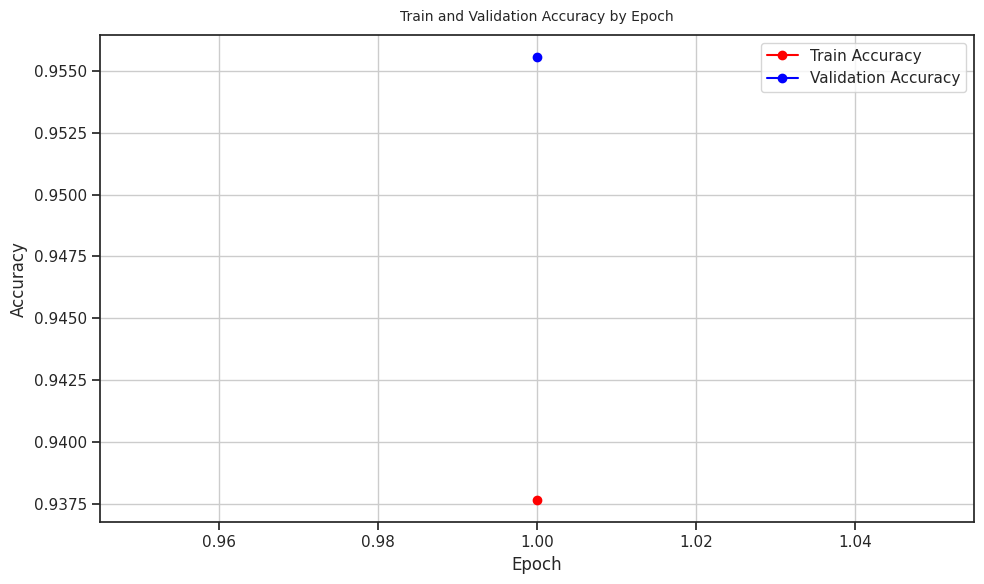

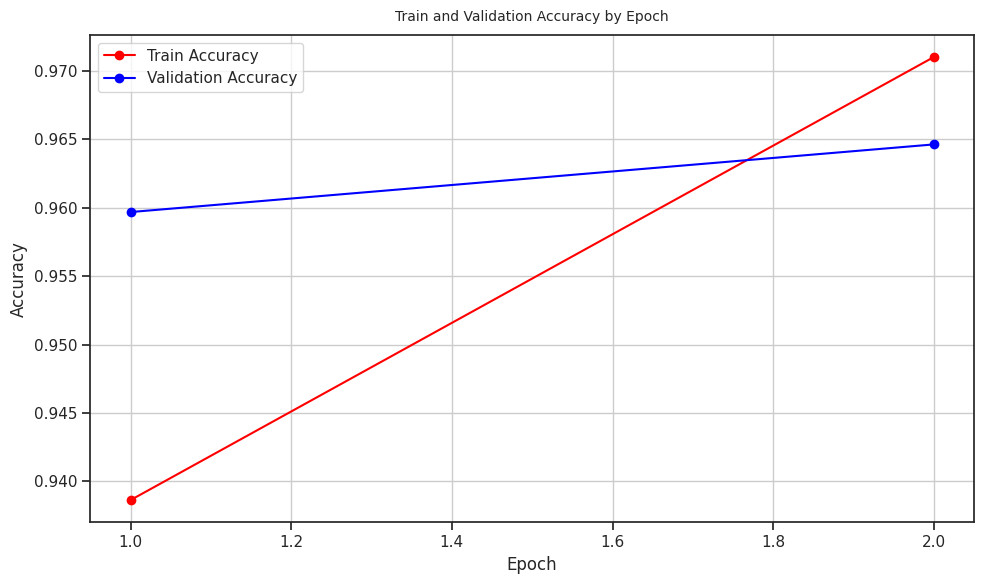

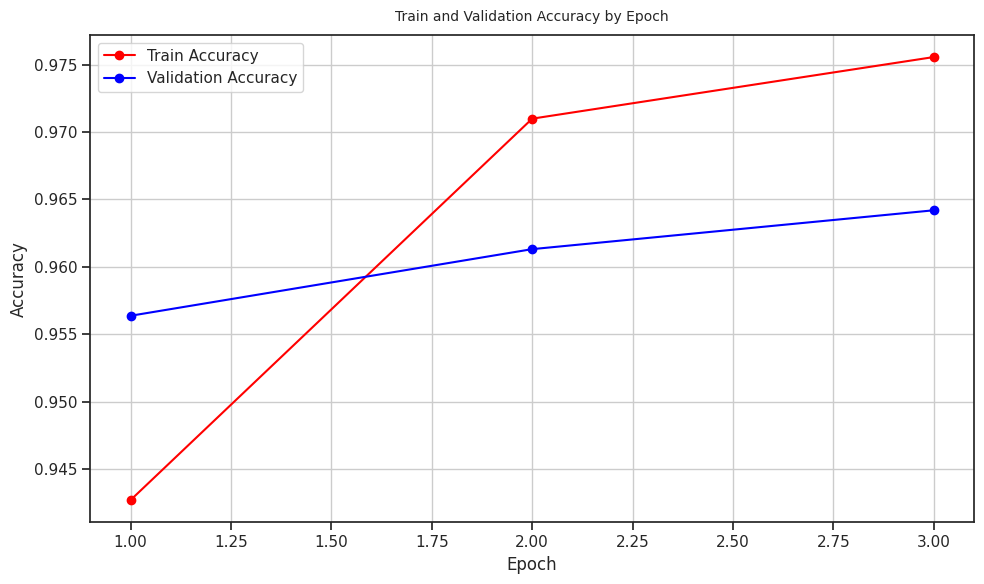

In [ ]:
for dataframe in results:
  plt.figure(figsize=(10, 6))
  plt.plot(dataframe['epoch'], dataframe['train_accuracy'], marker='o', label='Train Accuracy', color = 'red')
  plt.plot(dataframe['epoch'], dataframe['val_accuracy'], marker='o', label='Validation Accuracy', color = 'blue')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title('Train and Validation Accuracy by Epoch')
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()
